# Optimización de Portafolios de Inversión

## Teoría Moderna del Portafolio (Markovitz)

### Portafolio de Mínima Varianza

In [46]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize

# tickers de acciones
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META"]
prices = yf.download(tickers, start='2023-01-01', end='2025-12-31')['Close']

# Calcular retornos diarios
returns = np.log(prices / prices.shift(1)).dropna()

# Matriz de covarianza anualizada
cov_matrix = returns.cov() * 252

# Función objetivo: minimizar la varianza del portafolio
def portfolio_variance(weights, cov_matrix):
    contribution_vector = np.dot(weights, cov_matrix)
    variance = np.dot(contribution_vector, weights)
    return variance

# Restricciones: suma de pesos = 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Límites: pesos entre 0 y 1 (no hay ventas en corto)
bounds = tuple((0, 1) for _ in range(len(tickers)))

# Peso inicial igual para todos los activos
initial_weights = np.array(len(tickers) * [1. / len(tickers)])

# Optimización
result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                  method='SLSQP', bounds=bounds, constraints=constraints)   
min_variance_weights = result.x

df_min_variance = pd.DataFrame({'Ticker': tickers, 'Optimal Weight': min_variance_weights})   
df_min_variance.sort_values(by='Optimal Weight', ascending=False, inplace=True)
df_min_variance['Optimal Weight'] = df_min_variance['Optimal Weight'].apply(lambda x: f"{x:.2%}")
df_min_variance.reset_index(drop=True, inplace=True)

# Retorno esperado y volatilidad del portafolio de mínima varianza
expected_returns = returns.mean() * 252
min_variance_return = np.dot(min_variance_weights, expected_returns)
min_variance_volatility = np.sqrt(portfolio_variance(min_variance_weights, cov_matrix))



[*********************100%***********************]  5 of 5 completed


### Portafolio Tangente

In [47]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize

# tickers de acciones
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META"]
prices = yf.download(tickers, start='2023-01-01', end='2025-12-31')['Close']

# Calcular retornos diarios
returns = np.log(prices / prices.shift(1)).dropna()

# Matriz de covarianza anualizada
cov_matrix = returns.cov() 

# Función objetivo: máximizar el ratio de Sharpe (rendimiento/volatilidad)
def negative_sharpe_ratio(weights, returns, cov_matrix):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio  # Negativo para maximizar

# Restricciones: suma de pesos = 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Límites: pesos entre 0 y 1 (no hay ventas en corto)
bounds = tuple((0, 1) for _ in range(len(tickers)))

# Peso inicial igual para todos los activos
initial_weights = np.array(len(tickers) * [1. / len(tickers)])

# Optimización
result = minimize(negative_sharpe_ratio, initial_weights, args=(returns, cov_matrix),
                  method='SLSQP', bounds=bounds, constraints=constraints)   
max_sharpe_weights = result.x
df_max_sharpe = pd.DataFrame({'Ticker': tickers, 'Optimal Weight': max_sharpe_weights})   
df_max_sharpe.sort_values(by='Optimal Weight', ascending=False, inplace=True)
df_max_sharpe['Optimal Weight'] = df_max_sharpe['Optimal Weight'].apply(lambda x: f"{x:.2%}")
df_max_sharpe.reset_index(drop=True, inplace=True)

# retorno esperado y volatilidad del portafolio de máxima Sharpe
max_sharpe_returm = np.sum(returns.mean() * max_sharpe_weights) * 252
max_sharpe_volatility = np.sqrt(np.dot(max_sharpe_weights.T, np.dot(cov_matrix, max_sharpe_weights))) * np.sqrt(252)

[*********************100%***********************]  5 of 5 completed


### Frontera Eficiente

[*********************100%***********************]  5 of 5 completed


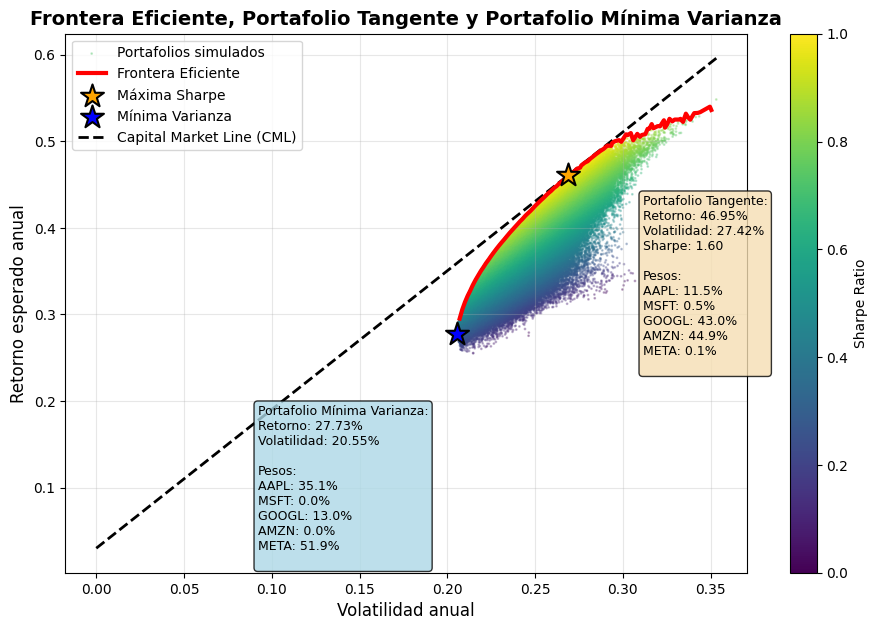

In [48]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======================================
# Parámetros
# ======================================
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META"]
start_date = "2023-01-01"
end_date = "2025-12-31"
n_portfolios = 1_000_000
rf = 0.03  # tasa libre de riesgo anual (3%)

np.random.seed(42)

# ======================================
# Descarga de precios
# ======================================
prices = yf.download(tickers, start=start_date, end=end_date)["Close"]

# Retornos logarítmicos diarios
returns = np.log(prices / prices.shift(1)).dropna()

# Media y covarianza
mean_returns = returns.mean().values * 252      # retorno esperado anual
cov_matrix = returns.cov().values * 252         # covarianza anualizada

n_assets = len(tickers)

# ======================================
# Simulación Monte Carlo
# ======================================
weights = np.random.random((n_portfolios, n_assets))
weights /= np.sum(weights, axis=1)[:, None]

# Retorno esperado del portafolio
portfolio_returns = weights @ mean_returns

# Volatilidad del portafolio
portfolio_vols = np.sqrt(
    np.einsum("ij,jk,ik->i", weights, cov_matrix, weights)
)

# Sharpe Ratio
sharpe_ratios = (portfolio_returns - rf) / portfolio_vols

# ======================================
# Identificar la Frontera Eficiente
# ======================================
# Dividir en bins de volatilidad y encontrar el máximo retorno en cada bin
n_bins = 100
vol_bins = np.linspace(portfolio_vols.min(), portfolio_vols.max(), n_bins)
efficient_frontier_vols = []
efficient_frontier_returns = []

for i in range(len(vol_bins) - 1):
    mask = (portfolio_vols >= vol_bins[i]) & (portfolio_vols < vol_bins[i + 1])
    if np.any(mask):
        max_return_idx = np.argmax(portfolio_returns[mask])
        efficient_frontier_vols.append(portfolio_vols[mask][max_return_idx])
        efficient_frontier_returns.append(portfolio_returns[mask][max_return_idx])

# ======================================
# Portafolio tangente (Máx Sharpe)
# ======================================
idx_tangent = np.argmax(sharpe_ratios)

ret_tangent = portfolio_returns[idx_tangent]
vol_tangent = portfolio_vols[idx_tangent]
weights_tangent = weights[idx_tangent]

# ======================================
# Capital Market Line (CML)
# ======================================
sigma_cml = np.linspace(0, portfolio_vols.max(), 200)
sharpe_max = sharpe_ratios[idx_tangent]
cml_returns = rf + sharpe_max * sigma_cml

# ======================================
# Gráfico
# ======================================
plt.figure(figsize=(11, 7))

# Todos los portafolios simulados
plt.scatter(
    portfolio_vols,
    portfolio_returns,
    c=sharpe_ratios,
    cmap="viridis",
    s=1,
    alpha=0.3,
    label="Portafolios simulados"
)

# Frontera eficiente resaltada
plt.plot(
    efficient_frontier_vols,
    efficient_frontier_returns,
    color='red',
    linewidth=3,
    label='Frontera Eficiente',
    zorder=5
)

# Portafolio tangente
plt.scatter(max_sharpe_volatility, max_sharpe_returm, color='orange', marker='*', s=300, 
            edgecolors='black', linewidths=1.5, label='Máxima Sharpe', zorder=6)

# Portafolio de mínima varianza
plt.scatter(min_variance_volatility, min_variance_return, color='blue', marker='*', s=300,
            edgecolors='black', linewidths=1.5, label='Mínima Varianza', zorder=6)

# Capital Market Line
plt.plot(
    sigma_cml,
    cml_returns,
    color="black",
    linewidth=2,
    linestyle='--',
    label="Capital Market Line (CML)",
    zorder=4
)

plt.xlabel("Volatilidad anual", fontsize=12)
plt.ylabel("Retorno esperado anual", fontsize=12)
plt.title("Frontera Eficiente, Portafolio Tangente y Portafolio Mínima Varianza", fontsize=14, fontweight='bold')
plt.colorbar(label="Sharpe Ratio")
plt.legend(loc='upper left', fontsize=10)
plt.grid(alpha=0.3)

# Añadir información del portafolio tangente en el gráfico
info_text = f"Portafolio Tangente:\n"
info_text += f"Retorno: {ret_tangent:.2%}\n"
info_text += f"Volatilidad: {vol_tangent:.2%}\n"
info_text += f"Sharpe: {sharpe_max:.2f}\n\n"
info_text += "Pesos:\n"
for t, w in zip(tickers, weights_tangent):
    info_text += f"{t}: {w:.1%}\n"

plt.gcf().text(0.65, 0.65, info_text, fontsize=9, 
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
               verticalalignment='top')

# Añadir información del portafolio de mínima varianza
info_text_minvar = f"Portafolio Mínima Varianza:\n"
info_text_minvar += f"Retorno: {min_variance_return:.2%}\n"
info_text_minvar += f"Volatilidad: {min_variance_volatility:.2%}\n\n"
info_text_minvar += "Pesos:\n"
for t, w in zip(tickers, min_variance_weights):
    info_text_minvar += f"{t}: {w:.1%}\n"

plt.gcf().text(0.30, 0.35, info_text_minvar, fontsize=9,
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
               verticalalignment='top')
plt.savefig(r'images/frontera_eficiente.png', dpi=300, bbox_inches='tight')

plt.show()

